# Taylor Zipft

For a corpus of words, Zipf's law (https://en.wikipedia.org/wiki/Zipf%27s_law) states that word frequency is proportional to 1/word rank.
That is, the most common word is twice as common as the second most common word, three times as common as the third most common word, etc.
Vsauce has a great video on this: https://youtu.be/fCn8zs912OE?si=_cOd19MaH5IGFzSx

As this Tidy Tuesday explores the work of Taylor Swift, I decided to explore how well her lyrics follow Zipf's law.
The lyrics didn't appear with the original Tidy Tuesday data for some reason, so I had to do some manual work to scrape them from the taylor R package https://github.com/wjakethompson/taylor


In [1]:
# Load initial data obtained from Tidy Tuesday and have a look at it
# https://github.com/rfordatascience/tidytuesday/blob/master/data/2023/2023-10-17/readme.md
import pandas as pd

df = pd.read_csv("taylor_album_songs.csv")
df.head(5)

,album_name,ep,album_release,track_number,track_name,artist,featuring,bonus_track,promotional_release,single_release,...,liveness,valence,tempo,time_signature,duration_ms,explicit,key_name,mode_name,key_mode,lyrics
0,Taylor Swift,False,2006-10-24,1,Tim McGraw,Taylor Swift,NaN,False,NaN,2006-06-19,...,0.1210,0.425,76.009,4.0,232107.0,False,C,major,C major,NaN
1,Taylor Swift,False,2006-10-24,2,Picture To Burn,Taylor Swift,NaN,False,NaN,2008-02-03,...,0.0962,0.821,105.586,4.0,173067.0,False,G,major,G major,NaN
2,Taylor Swift,False,2006-10-24,3,Teardrops On My Guitar,Taylor Swift,NaN,False,NaN,2007-02-19,...,0.1190,0.289,99.953,4.0,203040.0,False,A#,major,A# major,NaN
3,Taylor Swift,False,2006-10-24,4,A Place In This World,Taylor Swift,NaN,False,NaN,NaN,...,0.3200,0.428,115.028,4.0,199200.0,False,A,major,A major,NaN
4,Taylor Swift,False,2006-10-24,5,Cold As You,Taylor Swift,NaN,False,NaN,NaN,...,0.1230,0.261,175.558,4.0,239013.0,False,F,major,F major,NaN


See how in the above output, the lyrics column is empty! Annoying...

Let's manually get the lyric data. First we need to map the album names from the above table to the ones in the repo

In [2]:
# Manual mapping from df album name to lyric source album names
albums = df['album_name'].unique()
albums_github = dict(zip(albums, ["taylor-swift", "fearless", "speak-now", "red", "1989", "reputation", "lover", "folklore", "evermore", "midnights"]))
albums_github

{'Taylor Swift': 'taylor-swift',
 "Fearless (Taylor's Version)": 'fearless',
 'Speak Now': 'speak-now',
 "Red (Taylor's Version)": 'red',
 '1989': '1989',
 'reputation': 'reputation',
 'Lover': 'lover',
 'folklore': 'folklore',
 'evermore': 'evermore',
 'Midnights': 'midnights'}

We can use the above mapping to actually scrape the lyric data.

I attempted to do this for every song in the dataframe, but some are missing or in different album directories, so I settled with 144 songs from 10 albums

In [3]:
# Populate lyric data. This takes a little bit of time (< 1 min)
import requests

# Iterate over the album mapping defined above
for album_idx, (album, album_gh) in enumerate(albums_github.items()):
    album_df = df.loc[df['album_name'] == album]
    songs = album_df['track_name']
    n_found = 0

    print('Album: {:s}'.format(album))

    for idx, song in enumerate(songs):
        # This is a bit janky to get the correct song github name
        song_gh = '{:02d}_{:s}'.format(idx + 1, song.lower().replace(' ', '-').replace("'", '').replace('?', '').replace('-(taylors-version)', '').replace('-(oh-my-my-my)', '').replace('&', 'n').replace('...', '').replace('!', '').replace(',', ''))
        # Actually request the raw txt data if found
        url = "https://raw.githubusercontent.com/wjakethompson/taylor/main/data-raw/lyrics/{:02d}_{:s}/{:s}.txt".format(album_idx + 1, album_gh, song_gh)
        p = requests.get(url)
        if p.status_code == 200:
            df.loc[df['track_name'] == song, 'lyrics'] = p.text
            n_found += 1
        else:
            print('Could not find for {:s} -> {:s}'.format(song, song_gh))

    print('Num found: {:d}\n'.format(n_found))

df.head(5)

Album: Taylor Swift


C:\Users\jearly\AppData\Local\Temp\ipykernel_29828\30502272.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[Verse 1]
He said the way my blue eyes shined
Put those Georgia stars to shame that night
I said, "That's a lie"
Just a boy in a Chevy truck
That had a tendency of gettin' stuck
On backroads at night
And I was right there beside him all summer long
And then the time we woke up to find that summer gone

[Chorus]
But when you think Tim McGraw
I hope you think my favorite song
The one we danced to all night long
The moon like a spotlight on the lake
When you think happiness
I hope you think that little black dress
Think of my head on your chest
And my old faded blue jeans
When you think Tim McGraw
I hope you think of me

[Verse 2]
September saw a month of tears
And thankin' God that you weren't here
To see me like that
But in a box beneath my bed
Is a letter that you never read
From three summers back
It's 

Could not find for I'm Only Me When I'm With You -> 12_im-only-me-when-im-with-you
Could not find for Invisible -> 13_invisible
Could not find for A Perfectly Good Heart -> 14_a-perfectly-good-heart
Could not find for Teardrops On My Guitar (Pop Version) -> 15_teardrops-on-my-guitar-(pop-version)
Num found: 11

Album: Fearless (Taylor's Version)
Could not find for Jump Then Fall (Taylor's Version) -> 14_jump-then-fall
Could not find for Untouchable (Taylor's Version) -> 15_untouchable
Could not find for Forever & Always (Piano Version) [Taylor's Version] -> 16_forever-n-always-(piano-version)-[taylors-version]
Could not find for Come In With The Rain (Taylor's Version) -> 17_come-in-with-the-rain
Could not find for SuperStar (Taylor's Version) -> 18_superstar
Could not find for The Other Side Of The Door (Taylor's Version) -> 19_the-other-side-of-the-door
Could not find for Today Was A Fairytale (Taylor's Version) -> 20_today-was-a-fairytale
Could not find for You All Over Me (Taylor's

,album_name,ep,album_release,track_number,track_name,artist,featuring,bonus_track,promotional_release,single_release,...,liveness,valence,tempo,time_signature,duration_ms,explicit,key_name,mode_name,key_mode,lyrics
0,Taylor Swift,False,2006-10-24,1,Tim McGraw,Taylor Swift,NaN,False,NaN,2006-06-19,...,0.1210,0.425,76.009,4.0,232107.0,False,C,major,C major,[Verse 1]\nHe said the way my blue eyes shined...
1,Taylor Swift,False,2006-10-24,2,Picture To Burn,Taylor Swift,NaN,False,NaN,2008-02-03,...,0.0962,0.821,105.586,4.0,173067.0,False,G,major,G major,"[Verse 1]\nState the obvious, I didn't get my ..."
2,Taylor Swift,False,2006-10-24,3,Teardrops On My Guitar,Taylor Swift,NaN,False,NaN,2007-02-19,...,0.1190,0.289,99.953,4.0,203040.0,False,A#,major,A# major,[Verse 1]\nDrew looks at me\nI fake a smile so...
3,Taylor Swift,False,2006-10-24,4,A Place In This World,Taylor Swift,NaN,False,NaN,NaN,...,0.3200,0.428,115.028,4.0,199200.0,False,A,major,A major,"[Verse 1]\nI don't know what I want, so don't ..."
4,Taylor Swift,False,2006-10-24,5,Cold As You,Taylor Swift,NaN,False,NaN,NaN,...,0.1230,0.261,175.558,4.0,239013.0,False,F,major,F major,[Verse 1]\nYou have a way of coming easily to ...


We can see that there is now lyric data for (some of) the songs! We'll clean it later

I also wanted to get some colour palettes based on album covers.
There is another R package for this https://github.com/asteves/tayloRswift, so I manually copied the colours from there.

I then do a bit of visualisation and make some custom palettes.

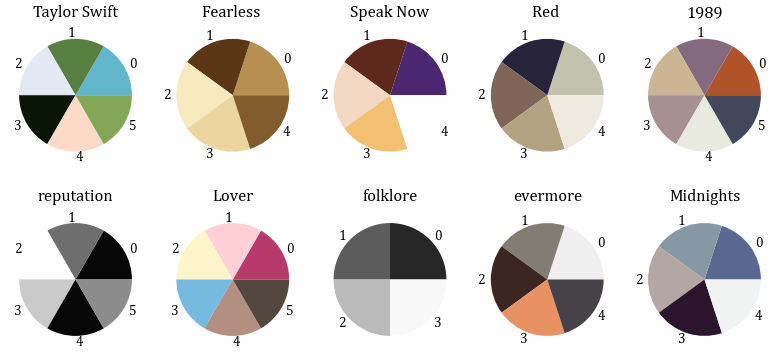

In [6]:
# Album colour palettes
# From https://github.com/asteves/tayloRswift/blob/main/R/colors.R
from matplotlib import pyplot as plt

# Set style - must keep import
import scienceplots
plt.style.use(['science', 'no-latex'])
plt.rcParams["font.family"] = "Cambria"
plt.rcParams["font.size"] = 10

# Fixed colour values
p_taylorSwift = ["#61b6cc", "#577f3f", "#e3e9f3", "#0a1605", "#fddac7", "#81a757"]
p_fearless = ["#b68f51","#5b3617","#f7eabe", "#ecd59f","#825c2d"]
p_speakNow = ["#4b2671","#5e291c", "#f3d8c4","#f3bf73","#ffffff"]
p_red = ["#c2c2ae","#26233b","#7f6557", "#b4a382","#eeeadf"]
p_1989 = ["#b1532a","#84697f","#cbb593","#a88f92","#e8eadf", "#43475b"]
p_reputation = ["#060606","#6e6e6e","#fefefe","#cacaca", "#060606","#8c8c8c"]
p_lover = ["#b8396b","#ffd1d7","#fff5cc","#76bae0","#b28f81","#54483e"]
p_folklore = ["#272727","#5c5c5c","#bababa", "#f8f8f8"]
p_evermore = ["#efefef","#827d73", "#3d2620", "#e89264","#474247"]
p_midnights = ["#586891","#8897A4","#B3A6A3","#2B152C","#F1F3F2"]

p_all = [p_taylorSwift, p_fearless, p_speakNow, p_red, p_1989, p_reputation, p_lover, p_folklore, p_evermore, p_midnights]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4))
for p, palette in enumerate(p_all):
    axes[p // 5, p % 5].pie([1] * len(palette), colors=palette, labels=range(len(palette)))
    axes[p // 5, p % 5].set_title(albums[p].replace("(Taylor's Version)", ""))

plt.tight_layout()
plt.show()

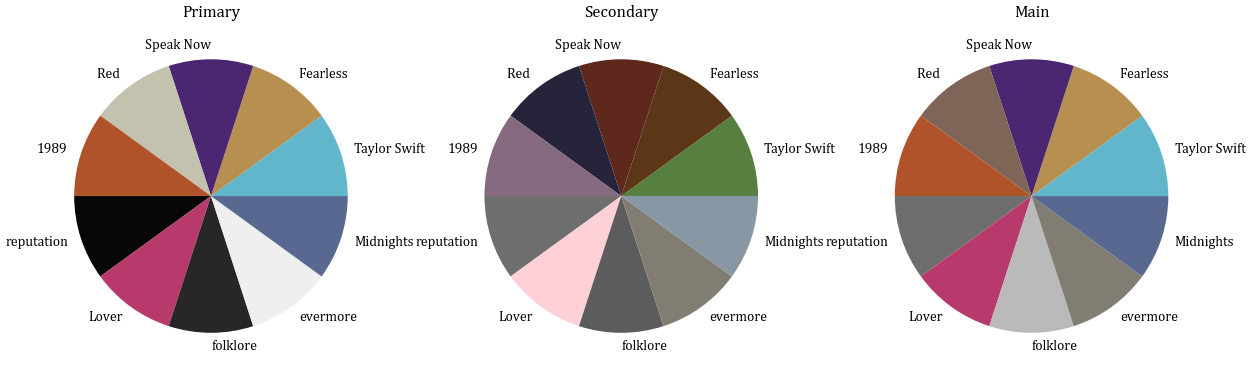

In [9]:
# Visualise primary and secondary colours in all album palettes
p_primary = [p[0] for p in p_all]
p_secondary = [p[1] for p in p_all]

# Also create my own main palette to fix dark colour or clashes
p_main = []
selection = [0, 0, 0, 2, 0, 1, 0, 2, 1, 0]
for i, p in enumerate(p_all):
    p_main.append(p[selection[i]])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].pie([1] * len(p_primary), colors=p_primary, labels=[a.replace("(Taylor's Version)", "") for a in albums])
axes[0].set_title('Primary')
axes[1].pie([1] * len(p_secondary), colors=p_secondary, labels=[a.replace("(Taylor's Version)", "") for a in albums])
axes[1].set_title('Secondary')
axes[2].pie([1] * len(p_main), colors=p_main, labels=[a.replace("(Taylor's Version)", "") for a in albums])
axes[2].set_title('Main')
plt.show()

With some colours set up, we now need to set up some vocabularies and clean the lyric data.

This involves a couple of functions for calculating Zipf distributions, a Vocab class for storing word counts and ranks, and a cleaning function.
For the Zipf distribution, I use a general version with a single parameter s, see https://en.wikipedia.org/wiki/Zipf%27s_law#Formal_definition
This means we can do a small amount of model fitting for different vocabs.

The Zipf distribution can be considered a straight line in log-log space. The parameter s determines the slope, and the intercept is determined by harmonic numbers.

We end up with a vocab for all the lyrics we have songs for.


In [11]:
# Clean and create vocab lyrics
import re
import string
from collections import Counter
import numpy as np
import scipy


# Zipf functions. Harmonic numbers could probably be calculated more efficiently or cached.
def _harmonic_num(n, s):
    # n is the total number of elements (ranks), and s is a parameter in the Zipf distribution.
    a = np.arange(n) + 1
    return np.sum(1/(a ** s))


def zipf_func(ranks, n_elem, s):
    # n_elem is the total number of ranks (number of words in vocab)
    # ranks is an array of rank positions we want to calculate expected frequencies for (normally 1,...,n_elem)
    h = _harmonic_num(n_elem, s)
    return 1/h * 1/(ranks ** s)


# Vocab object for storing information about different sets of words
class Vocab:

    def __init__(self, lyrics_df):
        # Get lyrics, clean them, and get occurrences of each word
        all_lyrics = []
        for raw_lyrics in lyrics_df['lyrics']:
            all_lyrics += clean_lyrics(raw_lyrics)
        self.freq_dict = Counter(all_lyrics)

        # Form arrays of words and their counts. Sort by frequency.
        self.size = len(self.freq_dict)
        vocab_words = np.asarray(list(self.freq_dict.keys()))
        vocab_counts = np.asarray(list(self.freq_dict.values()))
        sorted_idxs = np.argsort(vocab_counts)[::-1]
        self.counts = vocab_counts[sorted_idxs]
        self.words = vocab_words[sorted_idxs]

        # Fit Zipf curve
        self.s, self.error = self.fit_zipf()

    def fit_zipf(self):

        # Calculate squared error in log-log space (line is fit in that space to give equal weight to all ranks)
        def error_least_squares_log(_s):
            probas = self.counts / np.sum(self.counts)
            log_probas = np.log10(probas)
            # Expected log probas based on value of parameter s
            model_log_probas = np.log10(zipf_func(np.arange(self.size) + 1, self.size, _s))
            sum_of_square_loss = np.sum((log_probas - model_log_probas) ** 2)
            return sum_of_square_loss

        # Fit s parameter to minimise least squares in log-log space, starting from a value of 1
        s_init = 1
        s = scipy.optimize.minimize(error_least_squares_log, [s_init], bounds=[(0.1, 3.0)]).x[0]
        least_squares_error = error_least_squares_log(s)
        return s, least_squares_error


# Custom list of words to be removed when cleaning, could be expanded
WORDS_TO_REMOVE = ['']


def clean_lyrics(lyrics):
    # Make lowercase
    l = lyrics.lower()
    # Remove markers for verse, outro, etc. e.g., [verse 1]
    l = re.sub(r'\[.*?\]', '', l)
    # Replace new lines with spaces
    l = re.sub('\n', ' ', l)
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    l = l.translate(translator)
    # Remove trailing whitespace
    l = l.strip()
    # Remove spaces greater than length of one
    l = re.sub(' +', ' ', l)
    # Remove non ascii characters
    l = l.encode("ascii", "ignore").decode()
    # Remove numbers
    l = re.sub(r'[0-9]+', '', l)
    # Split and remove words we don't want
    l = l.split(' ')
    l = [w for w in l if w not in WORDS_TO_REMOVE]
    return l


# Create complete vocab for all songs we have lyrics for
complete_df = df[df['lyrics'].notna()]
complete_vocab = Vocab(complete_df)

# Basic outputs
print('\nVocab size:', complete_vocab.size)
print('\nTop 10 Words:')
for i in range(10):
    print(complete_vocab.words[i], complete_vocab.counts[i])

# Output list of single use words - looks like there are spelling mistakes (missing spaces)
single_idxs = np.where(complete_vocab.counts == 1)[0]
single_words = complete_vocab.words[single_idxs]
print('\n{:d} Single Use Words:'.format(len(single_idxs)))
print(np.sort(single_words))



Vocab size: 3471

Top 10 Words:
you 2421
i 2387
the 1875
and 1458
to 934
me 930
a 884
it 864
my 799
in 783

1423 Single Use Words:
['absentmindedly' 'absurd' 'abusive' ... 'yogurt' 'youpainted' 'yousay']



During the cleaning, I don't do any stemming or such, so we might end up with some junk.
Using a spell checker (en_US), there are 3109 correct words and 362 incorrect.

Some are lyrical misspellings, e.g. movin, or cases where punctuation has been removed, e.g. mustve.
There are also duplicates for things like ooh and mmm.

I couldn't be bothered to try and deal with this...


In [12]:
# Check spelling of every word in vocab
import enchant

alphabetical_words = np.sort(complete_vocab.words)
print(alphabetical_words)
spell_checker = enchant.Dict("en_US")

incorrect = 0
for word in alphabetical_words:
    if not spell_checker.check(word):
        print(word, complete_vocab.freq_dict[word])
        incorrect += 1

print('\n{:d} correct'.format(complete_vocab.size - incorrect))
print('{:d} incorrect'.format(incorrect))


['a' 'abigail' 'about' ... 'yourself' 'yousay' 'youve']
achilles 1
ahah 5
ahahah 3
aint 50
alls 1
american 10
americana 3
anticipatin 2
arent 7
arunning 4
ateam 10
axe 2
ayy 3
babylon 1
babys 6
backroads 1
baitandswitch 2
balancin 1
baller 1
bandaids 2
beggin 2
bein 1
benz 1
betty 5
bleedin 1
bloodsoaked 1
bonnie 1
borealis 1
breakin 2
bridetobe 1
brixton 1
btween 1
burnin 3
buzzcut 1
caf 4
callin 1
camden 1
changin 1
chasin 1
cheapassscrewtop 1
christmas 2
citys 1
clappin 3
cliffside 2
clyde 1
comin 3
comingofage 1
copout 1
corey 1
coreys 1
cornelia 16
couldnt 19
couldve 15
creepin 1
crossin 1
cruisin 2
cryin 2
dadadada 1
daddys 2
dal 1
dancin 5
darlin 1
daughterinlaw 1
dayold 2
deadend 2
december 13
deconstructors 1
didnt 77
disruptors 1
dividin 1
doesnt 16
doin 12
dont 329
dorothea 8
doublecrossed 1
dreamscapes 1
dreamt 1
dressin 4
drinkin 1
drivin 4
dyin 3
eeheeheeh 4
eightynine 1
eightyseven 1
este 1
estes 4
everchanging 1
everpresent 1
everybodys 1
everyones 4
everythings 2
evryo


Let's actually have a look at the vocab that we've got now.

This involves a function for plotting the word distribution (freq vs rank) in both normal space and log-log space.
In both cases, we can compare to the expected Zipf line (using the model we fit before).


Using Zipf curve with s = 1.12811


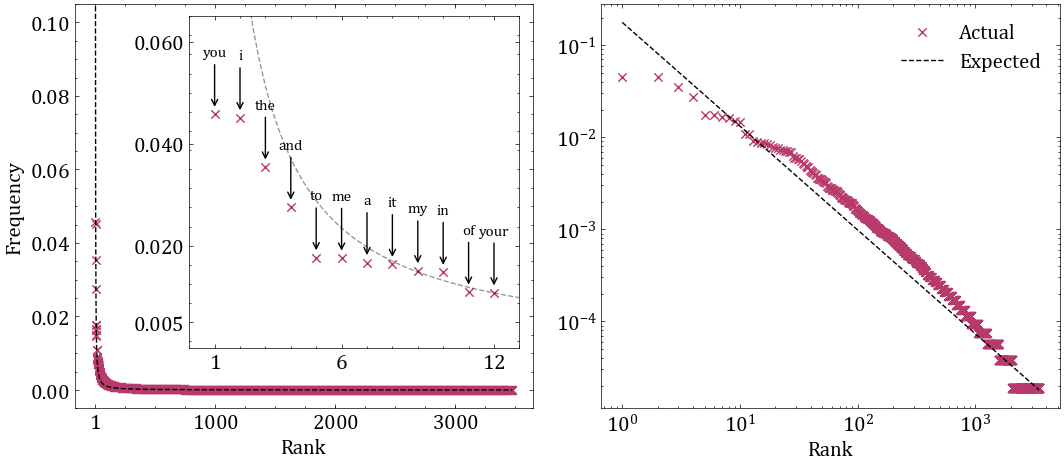

In [14]:
# Output for complete vocab
import numpy as np

plt.rcParams["font.size"] = 15


def plot_counts(vocab, inset_lim=12):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

    # Integer ranks
    xs = np.arange(vocab.size) + 1
    # Float ranks for smoother expected curve
    smooth_xs = np.linspace(1, vocab.size + 2, vocab.size * 4)

    print('Using Zipf curve with s = {:.5f}'.format(vocab.s))
    # Word freqs are the true values
    word_freqs = vocab.counts / np.sum(vocab.counts)
    # Expected freqs are the Zipf expected values
    expected_freqs = zipf_func(smooth_xs, vocab.size, vocab.s)

    # Plot normal space distribution
    axes[0].scatter(xs, word_freqs, label='Actual', marker='x', color='#b8396b')
    axes[0].plot(smooth_xs, expected_freqs, label='Expected', linestyle='--', color='black')
    axes[0].set_xlabel('Rank')
    axes[0].set_ylabel('Frequency')

    # Plot zoomed version inset
    axin = axes[0].inset_axes([0.25, 0.15, 0.72, 0.82])
    axin.scatter(xs[:inset_lim], word_freqs[:inset_lim], label='Actual', marker='x', color='#b8396b')
    axin.plot(smooth_xs, expected_freqs, label='Expected', linestyle='--', color='black', alpha=0.4)
    axin.set_xlim(0, inset_lim + 1)
    axin.set_ylim(0, word_freqs[0] * 1.22)
    for i, c in enumerate(word_freqs[:inset_lim]):
        axin.annotate(
            vocab.words[i], xy=(i+1, c + word_freqs[0] * 0.02), arrowprops={'facecolor': 'w', 'arrowstyle': '->'},
            xytext=(i + 1, c + word_freqs[0] * 0.25), horizontalalignment='center', fontsize=11,
        )

    # Plot log-log distribution
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].scatter(xs, word_freqs, label='Actual', marker='x', color='#b8396b')
    axes[1].plot(smooth_xs, expected_freqs, label='Expected', linestyle='--', color='black')
    axes[1].legend(loc='best')
    axes[1].set_xlabel('Rank')
    return fig, axes, axin


# Plot complete vocab and adjust
complete_fig, complete_axes, complete_axin = plot_counts(complete_vocab)
complete_axes[0].set_xticks([1, 1000, 2000, 3000])
complete_axes[0].set_ylim(-0.005, 0.105)
complete_axes[0].set_yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10])
complete_axin.set_xticks([1, 6, 12])
complete_axin.set_yticks([0.005, 0.02, 0.04, 0.06])
complete_axin.set_ylim(0, 0.065)

plt.tight_layout()
plt.show()

complete_fig.savefig("complete_vocab.png", dpi=300, transparent=True)



Looks quite nice! Top words are below where the Zipf distribution would expect them to be.
Overall log-log line is pretty straight though.

What about per album? First we need to create a vocab for each album



Taylor Swift
Vocab size: 596
Err: 6.317869719354773

Fearless (Taylor's Version)
Vocab size: 741
Err: 7.282114253633681

Speak Now
Vocab size: 911
Err: 11.093778847950041

Red (Taylor's Version)
Vocab size: 827
Err: 8.99163031497875

1989
Vocab size: 689
Err: 10.803145836650485

reputation
Vocab size: 932
Err: 12.763287421580804

Lover
Vocab size: 1013
Err: 10.231720545313761

folklore
Vocab size: 1011
Err: 6.1026841531520795

evermore
Vocab size: 1027
Err: 6.467551506140881

Midnights
Vocab size: 849
Err: 7.493828489108398


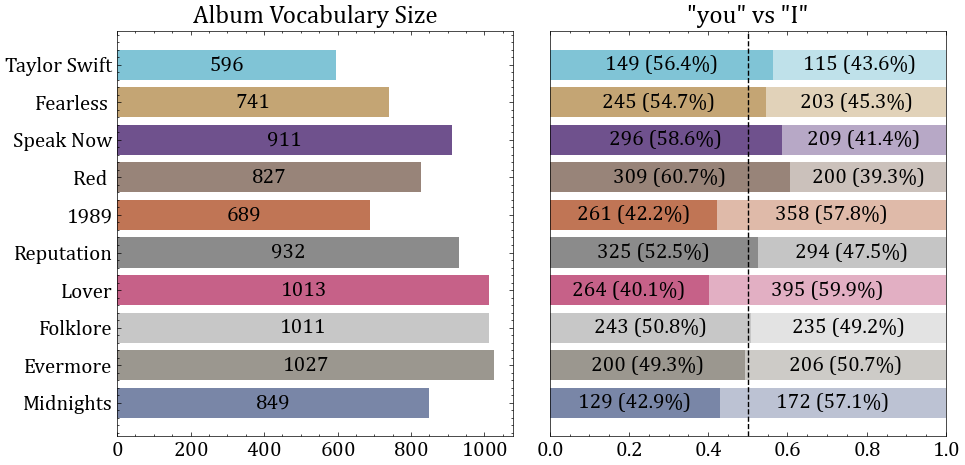

In [16]:
# Per album analysis
albums = complete_df['album_name'].unique()

# Create vocabs and add details
album_vocabs = []
for album_name in albums:
    album_df = complete_df[complete_df['album_name'] == album_name]
    album_vocab = Vocab(album_df)
    album_vocab.norm_size = album_vocab.size / len(album_df)
    album_vocabs.append(album_vocab)
    print('\n' + album_name)
    print('Vocab size:', album_vocab.size)
    print('Err:', album_vocab.error)

# Get list of vocab sizes
vocab_sizes = [v.size for v in album_vocabs]
# Get uses of "you" and "i" in each album, and calculate proportions
num_yous = np.asarray([v.freq_dict['you'] for v in album_vocabs])
num_is = np.asarray([v.freq_dict['i'] for v in album_vocabs])
prop_yous = num_yous/(num_yous + num_is)
prop_is = num_is/(num_yous + num_is)

# Plot album sizes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ys = np.arange(len(vocab_sizes))
bars0 = axes[0].barh(ys, vocab_sizes, color=p_main, alpha=0.8)
axes[0].bar_label(bars0, label_type='center', labels=vocab_sizes)
axes[0].set_yticks(ys, [name.replace("(Taylor's Version)", "").title() for name in albums])
axes[0].invert_yaxis()
axes[0].set_title('Album Vocabulary Size')

# Plot ration of "you" to "i"
bars1 = axes[1].barh(ys, prop_yous, color=p_main, label=num_yous, alpha=0.8)
axes[1].bar_label(bars1, label_type='center', labels=["{:d} ({:.1f}%)".format(n, p) for n, p in zip(num_yous, prop_yous * 100)])
bars2 = axes[1].barh(ys, prop_is, left=prop_yous, color=p_main, alpha=0.4)
axes[1].bar_label(bars2, label_type='center', labels=["{:d} ({:.1f}%)".format(n, p) for n, p in zip(num_is, prop_is * 100)])
axes[1].invert_yaxis()
axes[1].axvline(0.5, linestyle='--', color='black')
axes[1].set_xlim(0, 1)
axes[1].set_title('"you" vs "I"')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

fig.savefig("album_breakdown.png", dpi=300, transparent=True)



And what about the Zipf distributions for the album with the lowest error (Folklore) and the highest (Reputation)?

The word annotations and limits are a bit funky, but I'm not using the left plot in the final output so it's fine.


Using Zipf curve with s = 0.94058


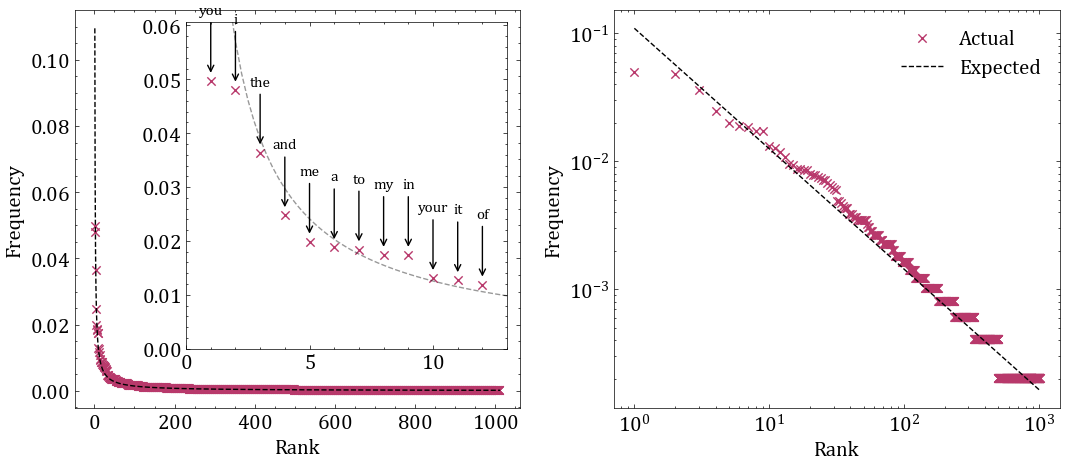

In [17]:
# Folklore output
album_vocab = album_vocabs[7]
album_fig, album_axes, _ = plot_counts(album_vocab)
album_axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
album_fig.savefig("folklore_freq.png", dpi=300, transparent=True)

Using Zipf curve with s = 1.03798


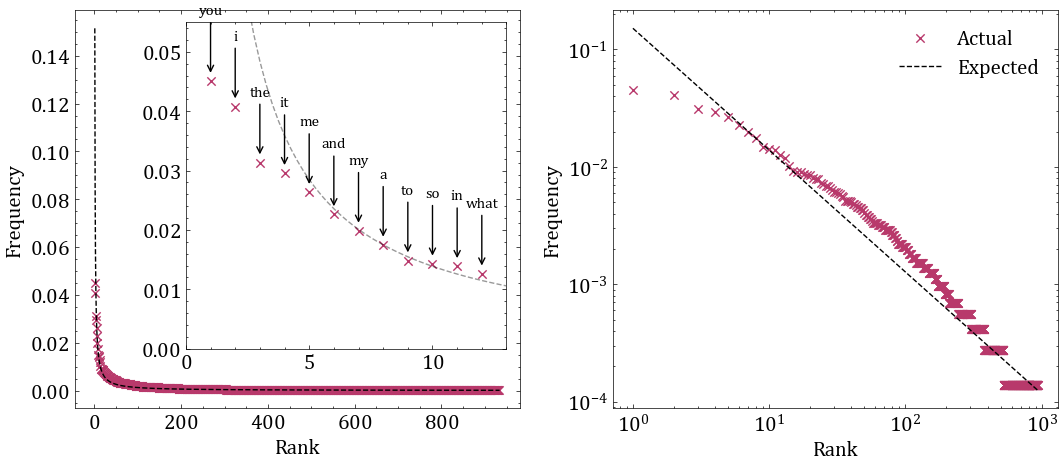

In [18]:
# Reputation output
album_vocab = album_vocabs[5]
album_fig, album_axes, _ = plot_counts(album_vocab)
album_axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
album_fig.savefig("reputation_freq.png", dpi=300, transparent=True)